# Stock Trading Strategy using Machine Learning (Linear Regression, KNN, Random Forest and SVM) - A comparision study 




## Introduction:
The goal of this project is to develop a stock trading strategy using the predictions obtained from a learning algorithm. The developed learner predicts the change in stock price over the next five trading days using Linear Regression, Random Forest, KNN and SVM. Bollinger Bands, Momentum, Volatility and .... are the input features and the prediction is for the stock price after five trading days. Analysis was done on IBM,... data. Based on the predictions made, the system is expected to suggest a position of 100 shares long, 100 share short or no action. The process was started with a cash of $10,000.
***

### <font color =blue>Operation 1: Data collection and pruning</font>
1. Read data from .csv file obtained from yahoo finance. 
2. The files downloaded were chosen to have data for an additional month before and beyond the start and end dates respectively
3. Adj. Close data column was selected for our current analysis.
4. Forward and backward fill was performed for missing data
5. Adj. Close data was plotted for our understanding


                  IBM
Date                 
2007-11-30  76.883553
2007-12-03  77.358650
2007-12-04  77.943428
2007-12-05  79.061798
2007-12-06  80.187523


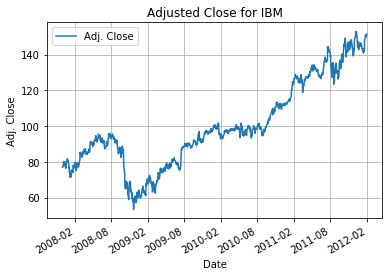

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime as dt
import pandas as pd

sd = dt.datetime(2007,11,30) 
ed = dt.datetime(2012,1,31)
syms=['IBM']
dates = pd.date_range(sd, ed)
dfAdj = pd.DataFrame(index=dates)
dfAdj = pd.read_csv(syms[0] + '.csv', index_col="Date", parse_dates=True, usecols=['Date', 'Adj Close'],na_values=['NaN'])    # Reading files from the data/xxx.csv. Also replacing missing values with NANs
dfAdj.head()
dfAdj = dfAdj.rename(columns={'Adj Close': syms[0]})     # Renaming the Adj Close column to the symbol
# Forward Fill / Back Fill
dfAdj.fillna(method='ffill', inplace=True)
dfAdj.fillna(method='bfill', inplace=True)
dfAdj = dfAdj.dropna()
print(dfAdj.head())



pl1 = dfAdj.plot(y='IBM',label='Adj. Close',title='Adjusted Close for '+syms[0],fontsize=10)
plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()
plt.show()


### <font color =blue>Operation 2: Feature Generation and Selection</font>
#### <font color =green>2a. Bollinger Bands</font>
Bollinger Bands is a technical analysis tool with two standard deviations sandwiching the Simple Moving Average (SMA) of a stock price. SMA is computed for a 20 day window along with the standard deviation for the same window. This band has three lines. 
1. The middle one for SMA values
2. The top and bottom ones are SMA +/- 2 standard deviations for the same moving window.
Typically, the average of first 20 days of data is considered for the 21st day average and the next days average is from day 2 to day 21 and so on. 

    - $ BU =SMA(Price,w) + 2* \sigma[Price,w]$
    - $ BL =SMA(Price,w) - 2* \sigma[Price,w]$
    - $ \sigma [Price,w]->$ Standard Deviation of the data in the window w
    - $ SMA(Price,w) ->$ Simple Moving Average
    
Further we normalize these values to bring the feature on the same scale as others. (Also called the 
[% B indicator](https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:bollinger_band_perce))
For the current work, additional one month data prior to the training window was considered inorder to accommodate a moving window for 20 days. Otherwise, around 20 data points are lost.

-0.8823314025239342
0.8876094239197582
-0.8562785472864328
0.8536470312750162


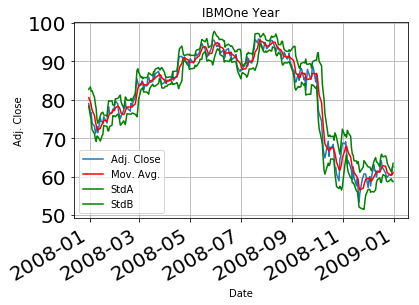

In [121]:
bolBand=pd.DataFrame()
wndwSize=5
bolBand['MVA_20']=dfAdj[syms[0]].rolling(window=wndwSize).mean()
bolBand['StdA_20']=bolBand['MVA_20']+2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['StdB_20']=bolBand['MVA_20']-2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['Std_20']=dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand[syms[0]]=dfAdj[syms[0]]
bolBand['BolNorm_20']=(bolBand[syms[0]]-bolBand['MVA_20'])/(2*bolBand['Std_20'])
print(bolBand['BolNorm_20'].min())
print(bolBand['BolNorm_20'].max())




mastData=bolBand
# We are reducing bolBand for visualizationin graphs
bolBand=bolBand.loc[dt.datetime(2007,12,31):dt.datetime(2008,12,31)]
ax=plt.figure(1)
ax=plt.gca()
bolBand.plot(y=syms[0],label='Adj. Close',title=syms[0],fontsize=20,ax=ax)
bolBand.plot(y='MVA_20',label='Mov. Avg.',title=syms[0],fontsize=20,color='red',ax=ax)
bolBand.plot(y='StdA_20',label='StdA',title=syms[0],fontsize=20,color='green',ax=ax)
bolBand.plot(y='StdB_20',label='StdB',title=syms[0] + ' One Year',fontsize=20,color='green',ax=ax)



plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()


#### <font color =green> 2b. Momentum </font>
Momentum indicates stock price strength. It indicates how fast or slow the stock prices change. It is just a difference of stock values over a window.
- Simply given as $ Momentum = P - P_n$
- where, P is current price and $P_n$ is the closing price before 'n' trading days.

In the current process, we considered momentum across various windows, expecting to use them as features for training our ML algorithms.

In [ ]:
#print(bolBand['Date'])

mNSize=10;
mNSize1=5;
mNSize2=20;
bolBand['Mom_10']=np.nan
bolBand['Mom_05']=np.nan
bolBand['Mom_20']=np.nan
bolBand['Mom_01']=np.nan
bolBand=bolBand.reset_index()

bolBand=bolBand.set_index('Date')


In [ ]:

for x in range(mNSize,bolBand['IBM'].count()):
    bolBand.at[x,'Mom_10']= (bolBand.loc[x,[syms[0]]])/ (bolBand.loc[x-mNSize,[syms[0]]])-1
    
for x in range(mNSize1,bolBand['IBM'].count()):
    bolBand.at[x,'Mom_05']= (bolBand.loc[x,[syms[0]]]-bolBand.loc[x-mNSize1,[syms[0]]])/ (bolBand.loc[x-mNSize1,[syms[0]]])

for x in range(mNSize2,bolBand['IBM'].count()):
    bolBand.at[x,'Mom_20']= (bolBand.loc[x,[syms[0]]])/ (bolBand.loc[x-mNSize2,[syms[0]]])-1
    
for x in range(mNSize2,bolBand['IBM'].count()):
    bolBand.at[x,'Mom_01']= (bolBand.loc[x,[syms[0]]])/ (bolBand.loc[x-1,[syms[0]]])-1


Computing Ys

In [ ]:
daysAhead=5;
bolBand['Y_5']=np.nan
for x in range(mNSize,bolBand['IBM'].count()-daysAhead-1):
    bolBand.at[x,'Y_5']= (bolBand.loc[x+daysAhead,[syms[0]]])/ (bolBand.loc[x,[syms[0]]])-1
    
    


Plots

In [ ]:


ax1=plt.figure(2)
ax1=plt.gca()


bolBand.plot(y='BolNorm_20',label='BolNorm_20',title=syms[0],fontsize=20,color='red',ax=ax1)
bolBand.plot(y='Mom_10',label='Mom_10',title=syms[0],fontsize=20,color='blue',ax=ax1)
bolBand.plot(y='Mom_05',label='Mom_05',title=syms[0],fontsize=20,color='green',ax=ax1)
bolBand.plot(y='Mom_20',label='Mom_20',title=syms[0],fontsize=20,color='yellow',ax=ax1)




plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()



ax2=plt.figure()
ax2=plt.gca()
#bolBand.plot(y='IBM',label='Y_5',title=syms[0],fontsize=20,ax=ax2)
bolBand.plot(y='Y_5',label='Y_5',title=syms[0],fontsize=20,ax=ax2)

Separating Data

In [ ]:
dfTraining=mastData.loc[dt.datetime(2007,12,31):dt.datetime(2010,12,31)]
print(dfTraining.tail())
dfTraining=dfTraining.reset_index()
#dfTrainingX=dfTraining[['MVA Norm','Mom_01','Mom_20','Mom_10','Mom_05']]
dfTrainingX=dfTraining[['MVA Norm','Mom_05']]
dfTrainingY=dfTraining['Y_5']
print(dfTraining.describe())


dfTesting=mastData.loc[dt.datetime(2010,12,31):dt.datetime(2011,12,31)]
print(dfTesting.tail())
dfTesting=dfTesting.reset_index()
#dfTestingX=dfTesting[['MVA Norm','Mom_01','Mom_20','Mom_10','Mom_05']]
dfTestingX=dfTesting[['MVA Norm','Mom_05']]
dfTestingY=dfTesting['Y_5']
print(dfTrainingX.head())
print(dfTrainingY.head())
print(dfTestingX.tail())
print(dfTestingY.tail())

print('Training Features Shape:', dfTrainingX.shape)
print('Training Labels Shape:', dfTrainingY.shape)
print('Testing Features Shape:', dfTestingX.shape)
print('Training Labels Shape:', dfTestingY.shape)


Train Model

In [ ]:
regression_model=LinearRegression()
regression_model.fit(dfTrainingX,dfTrainingY)
print(regression_model.coef_[0])
for idx, col_name in enumerate(dfTrainingX.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))
intercept=regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

regression_model.score(dfTrainingX,dfTrainingY)

from sklearn.metrics import mean_squared_error
y_predict=regression_model.predict(dfTrainingX)
regression_model_mse=mean_squared_error(y_predict,dfTrainingY)
regression_model_mse
import math
print("Training MSE is {}".format(math.sqrt(regression_model_mse)))


dfPredictedY = pd.DataFrame()
dfPredictedY['YP_5']=y_predict

ax4=plt.figure()
ax4=plt.gca()


dfTrainingY.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax4)
dfPredictedY.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax4)



new_predict=regression_model.predict(dfTestingX)
regression_model_mse=mean_squared_error(new_predict,dfTestingY)
regression_model_mse
import math
print("Testing MSE is {}".format(math.sqrt(regression_model_mse)))


dfPredictedY1 = pd.DataFrame()
dfPredictedY1['YP_5']=y_predict

ax3=plt.figure()
ax3=plt.gca()

dfTestingY1=dfTestingY.loc[0:200]
dfPredictedY1=dfPredictedY.loc[0:200]
dfPredictedY1=dfPredictedY1.shift(periods=5)
print(dfPredictedY1.head())
dfTestingY1.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax3)
dfPredictedY1.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax3)


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(dfTrainingX,dfTrainingY)
predictions=rf.predict(dfTestingX)
regression_model_mse=mean_squared_error(predictions,dfTestingY)
regression_model_mse
import math
print("Testing MSE is {}".format(math.sqrt(regression_model_mse)))
errors = abs(predictions - dfTestingY)
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = 100 * (errors / dfTestingY)

accuracy=100-np.mean(mape)
print(np.mean(mape))
print('Accuracy',round(accuracy,2),'%.')



dfPredictedY2 = pd.DataFrame()
dfPredictedY2['YP_5']=predictions

ax6=plt.figure()
ax6=plt.gca()

dfTestingY2=dfTestingY#.loc[0:200]
dfPredictedY2=dfPredictedY2#.loc[0:200]
dfPredictedY2=dfPredictedY2.shift(periods=5)
print(dfPredictedY2.head())
dfTestingY2.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax6)
dfPredictedY2.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax6)